<h2>Traffic Accidents Prediction

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler, MaxAbsScaler

<h3>Import the data

In [3]:
df=pd.read_csv("D://Accident//US_Accidents_March23.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [4]:
# Display Descriptive Statistics of data :
df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,7.728394e+06,7.728394e+06,7.728394e+06,4.325632e+06,4.325632e+06,7.728394e+06,7.564541e+06,5.729375e+06,7.554250e+06,7.587715e+06,7.551296e+06,7.157161e+06,5.524808e+06
mean,2.212384e+00,3.620119e+01,-9.470255e+01,3.626183e+01,-9.572557e+01,5.618423e-01,6.166329e+01,5.825105e+01,6.483104e+01,2.953899e+01,9.090376e+00,7.685490e+00,8.407210e-03
std,4.875313e-01,5.076079e+00,1.739176e+01,5.272905e+00,1.810793e+01,1.776811e+00,1.901365e+01,2.238983e+01,2.282097e+01,1.006190e+00,2.688316e+00,5.424983e+00,1.102246e-01
min,1.000000e+00,2.455480e+01,-1.246238e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.339963e+01,-1.172194e+02,3.346207e+01,-1.177543e+02,0.000000e+00,4.900000e+01,4.300000e+01,4.800000e+01,2.937000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.582397e+01,-8.776662e+01,3.618349e+01,-8.802789e+01,3.000000e-02,6.400000e+01,6.200000e+01,6.700000e+01,2.986000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.008496e+01,-8.035368e+01,4.017892e+01,-8.024709e+01,4.640000e-01,7.600000e+01,7.500000e+01,8.400000e+01,3.003000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900220e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01


<h3>Feature Addition

In [5]:
# Cast Start_Time to datetime 

df["Start_Time"] = pd.to_datetime(df["Start_Time"])

# Extract year, month, weekday and day
df["Year"] = df["Start_Time"].dt.year
df["Month"] = df["Start_Time"].dt.month
df["Weekday"] = df["Start_Time"].dt.weekday
df["Day"] = df["Start_Time"].dt.day

# Extract hour and minute
df["Hour"] = df["Start_Time"].dt.hour
df["Minute"] = df["Start_Time"].dt.minute

df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Weekday,Day,Hour,Minute
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,Night,Night,Night,Night,2016,2,0,8,5,46
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,Night,Night,Night,Day,2016,2,0,8,6,7
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,Night,Night,Day,Day,2016,2,0,8,6,49
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,Night,Day,Day,Day,2016,2,0,8,7,23
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,Day,Day,Day,Day,2016,2,0,8,7,39


<h3>Correlation matrix

C:\Users\USER\AppData\Local\Temp\ipykernel_17928\2837327486.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True);


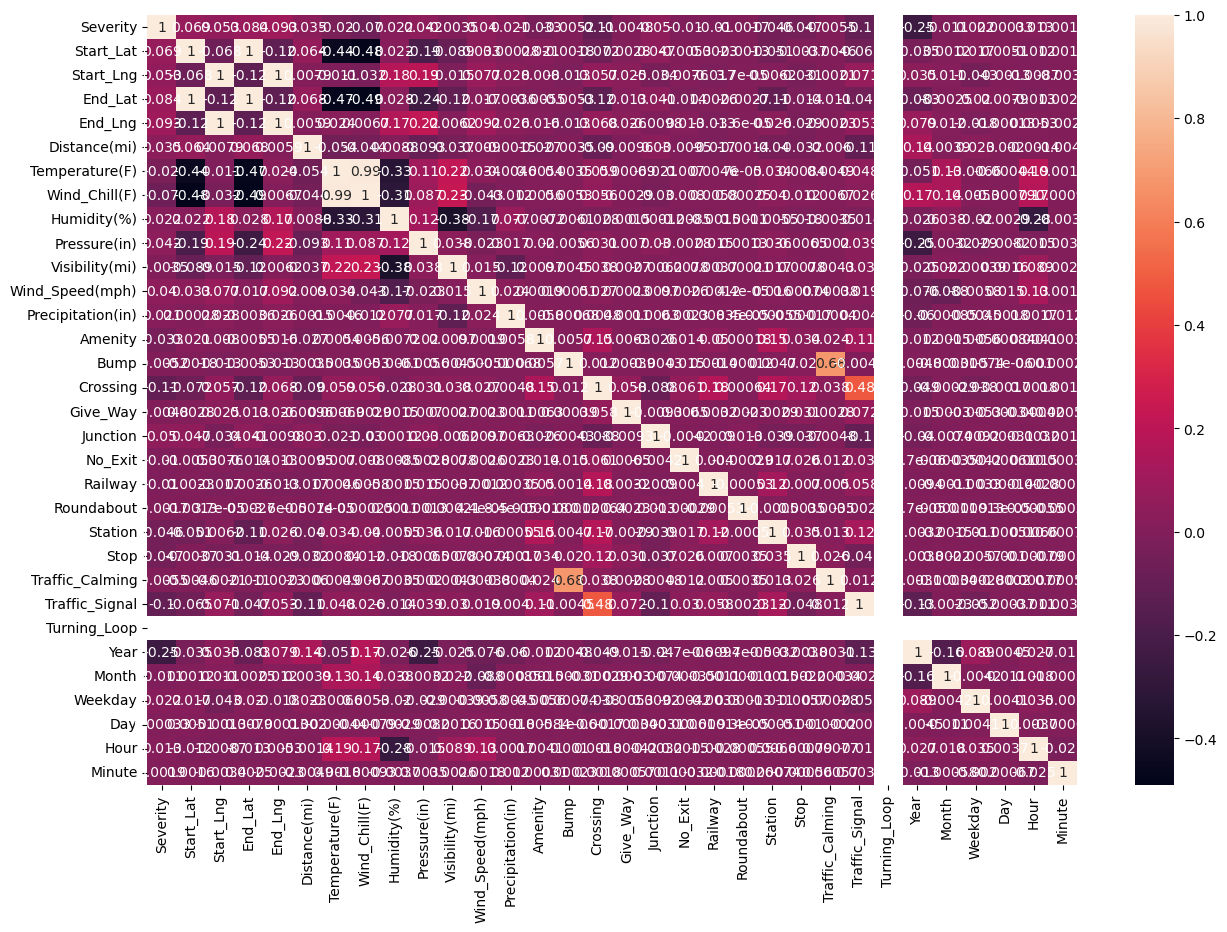

In [6]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot = True);
plt.show()

<h3>Selecting important Features

In [7]:
df=df.drop(['ID','State','Source','Start_Time','End_Time','Weather_Timestamp','End_Lat','End_Lng','Distance(mi)','Description','Street','City','County','Zipcode','Country','Wind_Direction','Timezone','Airport_Code','Traffic_Calming','Turning_Loop','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight'],axis=1)
df.info(verbose=True,show_counts=True)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Severity           7728394 non-null  int64  
 1   Start_Lat          7728394 non-null  float64
 2   Start_Lng          7728394 non-null  float64
 3   Temperature(F)     7564541 non-null  float64
 4   Wind_Chill(F)      5729375 non-null  float64
 5   Humidity(%)        7554250 non-null  float64
 6   Pressure(in)       7587715 non-null  float64
 7   Visibility(mi)     7551296 non-null  float64
 8   Wind_Speed(mph)    7157161 non-null  float64
 9   Precipitation(in)  5524808 non-null  float64
 10  Weather_Condition  7554935 non-null  object 
 11  Amenity            7728394 non-null  bool   
 12  Bump               7728394 non-null  bool   
 13  Crossing           7728394 non-null  bool   
 14  Give_Way           7728394 non-null  bool   
 15  Junction           7728394 non-n

(7728394, 29)

<h3> Data Preprocessing

In [8]:
# Check for Duplicates
def remove_duplicate(data):
    
    print("BEFORE REMOVING DUPLICATES - No. of Rows = ",data.shape[0])
    data.drop_duplicates(keep="first", inplace=True) 
    print("AFTER REMOVING DUPLICATES  - No. of Rows = ",data.shape[0])
    
    return "Checked Duplicates"

# Remove Duplicates from data :

remove_duplicate(df)


BEFORE REMOVING DUPLICATES - No. of Rows =  7728394
AFTER REMOVING DUPLICATES  - No. of Rows =  7232996


'Checked Duplicates'

In [9]:
df.nunique()

Severity                   4
Start_Lat            2428358
Start_Lng            2482533
Temperature(F)           860
Wind_Chill(F)           1001
Humidity(%)              100
Pressure(in)            1144
Visibility(mi)            92
Wind_Speed(mph)          184
Precipitation(in)        299
Weather_Condition        144
Amenity                    2
Bump                       2
Crossing                   2
Give_Way                   2
Junction                   2
No_Exit                    2
Railway                    2
Roundabout                 2
Station                    2
Stop                       2
Traffic_Signal             2
Sunrise_Sunset             2
Year                       8
Month                     12
Weekday                    7
Day                       31
Hour                      24
Minute                    60
dtype: int64

In [10]:
# Weather condition Data
unique_weather = df["Weather_Condition"].unique()
print(len(unique_weather))
print(unique_weather)

145
['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squalls' 'N/A Precipitation' 'Cloudy / Windy' 'Light Fog' 'Sand'
 'Sn

In [11]:
df.loc[df["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
df.loc[df["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
df.loc[df["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
df.loc[df["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
df.loc[df["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
df.loc[df["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
df.loc[df["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
df.loc[df["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
df.loc[df["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
df.loc[df["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
df.loc[df["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

print(df["Weather_Condition"].unique())

['Rain' 'Cloudy' 'Snow' 'Fog' 'Clear' nan 'Smoke' 'Thunderstorm' 'Sand'
 'Windy' 'Hail' 'Tornado']


In [12]:
# Display the Missing Values in Data :
df.isnull().sum()
df.shape
df.fillna(method='ffill', limit=5, inplace=True)
df.fillna(method='bfill', limit=5, inplace=True)

In [13]:
# Check missing values
df.dropna(subset=['Wind_Chill(F)','Wind_Speed(mph)','Pressure(in)','Precipitation(in)','Visibility(mi)'],inplace=True)
df.shape

(5455923, 29)

C:\Users\USER\AppData\Local\Temp\ipykernel_17928\2837327486.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot = True);


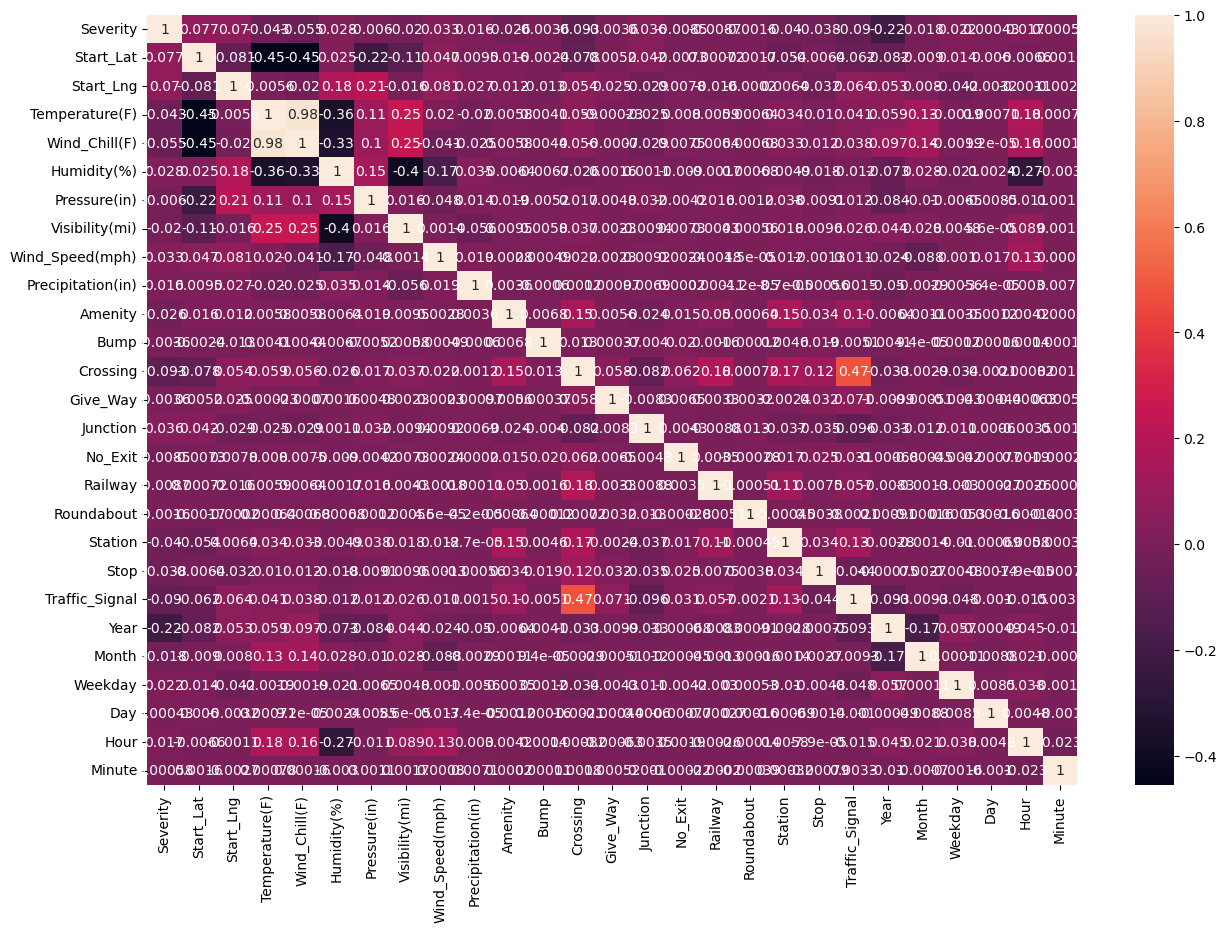

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot = True);
plt.show()

In [15]:
df.head()

,Severity,Start_Lat,Start_Lng,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Station,Stop,Traffic_Signal,Sunrise_Sunset,Year,Month,Weekday,Day,Hour,Minute
0,3,39.865147,-84.058723,36.9,33.3,91.0,29.68,10.0,3.5,0.02,...,False,False,False,Night,2016,2,0,8,5,46
1,2,39.928059,-82.831184,37.9,33.3,100.0,29.65,10.0,3.5,0.00,...,False,False,False,Night,2016,2,0,8,6,7
2,2,39.063148,-84.032608,36.0,33.3,100.0,29.67,10.0,3.5,0.00,...,False,False,True,Night,2016,2,0,8,6,49
3,3,39.747753,-84.205582,35.1,31.0,96.0,29.64,9.0,4.6,0.00,...,False,False,False,Night,2016,2,0,8,7,23
4,2,39.627781,-84.188354,36.0,33.3,89.0,29.65,6.0,3.5,0.00,...,False,False,True,Day,2016,2,0,8,7,39


In [16]:
nu=df.isnull().sum()
nu

Severity             0
Start_Lat            0
Start_Lng            0
Temperature(F)       0
Wind_Chill(F)        0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Signal       0
Sunrise_Sunset       0
Year                 0
Month                0
Weekday              0
Day                  0
Hour                 0
Minute               0
dtype: int64

In [17]:
df.nunique()

Severity                   4
Start_Lat            2067717
Start_Lng            2125677
Temperature(F)           785
Wind_Chill(F)            950
Humidity(%)              100
Pressure(in)            1134
Visibility(mi)            83
Wind_Speed(mph)          156
Precipitation(in)        280
Weather_Condition         11
Amenity                    2
Bump                       2
Crossing                   2
Give_Way                   2
Junction                   2
No_Exit                    2
Railway                    2
Roundabout                 2
Station                    2
Stop                       2
Traffic_Signal             2
Sunrise_Sunset             2
Year                       8
Month                     12
Weekday                    7
Day                       31
Hour                      24
Minute                    60
dtype: int64

<h3>Label Encoding

In [18]:
categorical_columns = df.select_dtypes(include=['object','bool']).columns
categorical_columns

Index(['Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Signal', 'Sunrise_Sunset'],
      dtype='object')

In [19]:
label_encoder = preprocessing.LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

<h3>Train Test Split

In [20]:
# Set the target for the prediction
target='Severity'
st='state'
y = df[target]
X = df.drop(target, axis=1)
# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
algo_lst=['Logistic Regression','Decision Trees','Random Forest','XGBoost']

accuracy_lst=[]

<h3>Logistic Regression

In [21]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Logistic regression algorithm] accuracy_score: 0.827.


<h3> Decision Tree

In [22]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)

dt_entropy.fit(X_train, y_train)

y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)

print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))

# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)

dt_gini.fit(X_train, y_train)

y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.833.
[Decision Tree -- gini] accuracy_score: 0.835.


<h3> Random Forest

In [25]:
# Random Forest algorithm

clf=RandomForestClassifier(n_estimators=20)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))

[Randon forest algorithm] accuracy_score: 0.847.


<h3>XG Boost

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [47]:
xgb_clf = XGBClassifier(n_estimators=100)


#Train the model using the training sets 
xgb_clf.fit(X_train,y_train)

y_pred = xgb_clf.predict(X_train)

# Get the accuracy score
acc=accuracy_score(y_train, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[XGBoost] accuracy_score: {:.3f}.".format(acc))

[XGBoost] accuracy_score: 0.852.


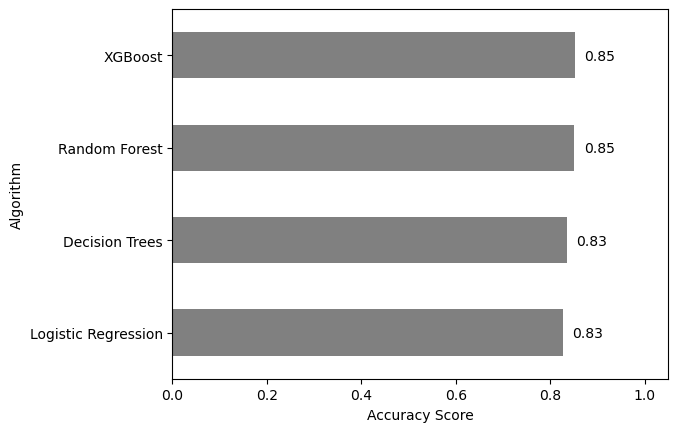

In [49]:
# Make a plot of the accuracy scores for different algorithms


y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)


ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

plt.xlim(0,1.05)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)

plt.show()

In [50]:
pip install -U nbconvert==5.6.1 --user

                                              0.0/455.1 kB ? eta -:--:--
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30.7/455.1 kB 1.3 MB/s eta 0:00:01
     --                                      30

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 2.5.0 requires nbconvert>=6.4.4, but you have nbconvert 5.6.1 which is incompatible.
